In [1]:

%load_ext memory_profiler

In [2]:
import numpy as np
import os
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

import h5py
import pandas as pd


from scipy import integrate

from scipy.signal import find_peaks
import re

import qetpy as qp



In [3]:
matplotlib.rc('font', size=16)          # controls default text sizes
matplotlib.rc('axes', titlesize=16)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=16)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=16)    # legend fontsize
matplotlib.rc('figure', titlesize=16)  # fontsize of the figure title
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.facecolor'] = 'w'
matplotlib.rc('figure.subplot', hspace=  0.4)

/home/s/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def record_length(configfile):
    with open(configfile) as f:
        return [int(re.search(r'\d+', line).group()) for line in f if r'RECORD_LENGTH' in line and not line.startswith('#')][0]
def process_data(trace, recordlength):
    try:
        traceR = trace.reshape(int(np.floor(len(trace)/recordlength)),recordlength)
    except ValueError:
        trace = trace[:int(np.floor(len(trace)/recordlength))*recordlength,]
        traceR = trace.reshape(int(np.floor(len(trace)/recordlength)),recordlength)
    data= traceR-np.expand_dims(traceR[:,100:1000].mean(axis=1), axis=1)
#     print ('input trace length',trace.shape, 'processed trace shape',  data.shape)
    return data
def norm_int_energy (data):
    energy = np.sum(data/np.min(data, axis =1)[:, None], axis =1)
    return energy
def int_energy (data):
    energy = np.sum(data, axis =1)
    return energy
def create_template(traces):
    template = np.mean(traces, axis = 0)
    template_norm= -template/min(template)
    return template, template_norm
def OF_calc(signal, template_norm, psd_noise, fs, noisevar, recordlength):
    amp, t0, chi2, fit_amp_min= [], [], [], []
    chi2_sav, chi2_my, chi2_array_varnoise = [], [], []
    integrated_fit_amp= []
    amp_pileup, t0_pileup, chi2_pileup = [], [], []
    data_amp_min = np.min(signal, axis =1)
    integrated_raw_amp = -np.sum(signal, axis =1)
    for trace in np.arange(len(signal)):
        OF = qp.OptimumFilter(signal[trace], template_norm, psd_noise, fs) # initialize the OptimumFilter class
        amp_withdelay, t0_withdelay, chi2_withdelay= OF.ofamp_withdelay() # t0_withdelay : time shift calculated for the pulse (in s).
        amp.append(amp_withdelay)
        t0.append(t0_withdelay)
        chi2.append(chi2_withdelay)
        fit_amp = amp_withdelay*np.roll(template_norm, round(t0_withdelay*fs))
        fit_amp_min.append(np.min(fit_amp )) 
#         integrated_fit_amp.append(-1* integrate.trapz(y = fit_amp, dx = 2e-9 ) )
#         integrated_raw_amp.append(-1* integrate.trapz(y = signal[trace], dx = 2e-9 ) )
        integrated_fit_amp.append(-np.sum(fit_amp) )

        chi2_sav.append((abs(signal[trace] - fit_amp).sum())/recordlength)
        chi2_my.append((((signal[trace] - fit_amp)**2/abs(fit_amp)).sum())/recordlength )
        chi2_array_varnoise.append ( (((signal[trace] - fit_amp)**2/noisevar).sum())/recordlength)

        
        amp_pu, t0_pu, chi2_pu = OF.ofamp_pileup_iterative(amp_withdelay, t0_withdelay)
        amp_pileup.append(amp_pu)
        t0_pileup.append(t0_pu)
        chi2_pileup.append(chi2_pu)

    return amp, t0, chi2, fit_amp_min, data_amp_min, chi2_sav, chi2_my, chi2_array_varnoise, integrated_raw_amp, integrated_fit_amp, amp_pileup, t0_pileup, chi2_pileup

t0_Tl = 7.322
t0_p = 7.336


In [5]:


def clippedwaveformsindex(data, clippingstart = -15100):
    clippedIdx = []
    data_max_idx = np.argmin(data, axis=1) 
    for i in range(len(data)):
        if data[i][data_max_idx[i]] < clippingstart:
            clippedIdx.append(i)
    return clippedIdx


def glitchesindex(data, threshold = 5):
    glitchesIdx = []
    
    std = ((data[:, 100:1000].std(axis=1)).reshape(len(data),1))
    t0idx = np.argmax(data<-(10*std), axis=1)   
        
    data_max_idx = np.argmin(data, axis=1)
    
    for i in range(len(data)):
        if data_max_idx[i] - t0idx[i] < threshold:
            glitchesIdx.append(i)
    return glitchesIdx


def pileupindex(data, ctype):
    pileupIdx, noisyIdx = [], []

    energy = np.sum(data/np.min(data, axis =1)[:, None], axis =1)
    
    if ctype == 'pure': distancefactor, prominencefactor = 15,  0.085
    else: distancefactor, prominencefactor = 200, 0.4
    if ctype == 'pure': threshold_min, threshold_max = 15,40
    else: threshold_min, threshold_max = 350,900
        
    data_max_idx = np.argmin(data, axis=1)
    data_max = data[np.arange(len(data_max_idx)),data_max_idx]  
    for i in range(0, len(data)):
        peaks, peak_properties = find_peaks(-data[i], prominence =(-data_max[i]*prominencefactor), distance=distancefactor)
        if len(peaks)>1 :
            pileupIdx.append(i)
        if energy[i] > threshold_max or energy[i] < threshold_min:
            noisyIdx.append(i)
    return pileupIdx, noisyIdx


In [8]:
%%time
flags = ['XFEL03/', 'XFEL04/', 'XFEL05/', 'XFEL06/', 'XFEL07/', 'XFELtesting/', 'XFEL_testing/']
for flag in flags:
    infolder = '../../../../../../../../media/s/SeagateHD/wavedumpdata/'+flag
#     infolder='./wavedumpdata/'
    outfolder='../../../../../../../../media/s/SeagateHD/new_neutron_template_output/'



    for inputfile in os.listdir(infolder):
        if inputfile.startswith('wavedump_pure_XFEL07_21-07-29_23-22-01') and inputfile.endswith('.txt'): 
            if os.path.exists(outfolder+inputfile[:-4]+'_new.hdf5'):
    #             continue
                os.remove(outfolder+inputfile[:-4]+'_new.hdf5')
#             print('input file is', inputfile)
            configfile= [file for file in os.listdir(infolder) if file.startswith('Config') and file.endswith(inputfile[-27:])]
#             print ('config file is',configfile, '\n', inputfile)
            block_size = 1000
            if len(configfile) == 0:  print('no config file for ', inputfile); recordlength = 15000
            else: 
                try: 
                    recordlength=record_length(infolder+configfile[0]) 
                except: print('empty config file for ', inputfile); recordlength = 15000

            chunksize = recordlength*block_size
            typ = inputfile[9:10]
            typ = 'p'

            if typ == 'T':
                var_noise = 7.029123062695451
                psd_noise = np.load('saved_outputs/psd_noise_Tl.npy')
                templateEM,  TemplateEM = create_template(np.load('templates/Tl_template_pulses.npy'))
                templateHAD,  TemplateHAD = create_template(np.load('templates/Tl_template_pulses_neutron.npy'))
                typ = 'Tl'
            if typ == 'p':
                var_noise = 7.296472588418061
                psd_noise = np.load('saved_outputs/psd_noise_pure.npy')
                templateEM,  TemplateEM = create_template(np.load('templates/pure_template_pulses.npy'))
                templateHAD,  TemplateHAD = create_template(np.load('templates/pure_neutron_all_amplitude_pulses_normalized.npy'))
                typ = 'pure'
            if typ == 0:
                print ("ERROR IN FILE NAME")

            try: chunks = pd.read_csv(infolder+inputfile, chunksize = chunksize, header = None)
            except: print('empty file') ; continue


            for i, chunk in enumerate (chunks):
                actual_block_size = int(chunk.shape[0]/recordlength)

                newdata = chunk[:actual_block_size*recordlength].values.reshape(actual_block_size, recordlength)

                newdata= newdata-np.expand_dims(newdata[:,100:1000].mean(axis=1), axis=1)
    #             print (newdata.shape)
                amp_withdelay, t0_withdelay, chi2_withdelay, fit_amp_min, data_amp_min, chi2_sav, chi2_my, chi2_varnoise, integrated_raw_amp, integrated_fit_amp, amp_pileup, t0_pileup, chi2_pileup= OF_calc(signal= newdata, 
                                                                                              template_norm = TemplateEM,
                                                                                              psd_noise = psd_noise[1],
                                                                                              fs = 1/2e-9, 
                                                                                              noisevar = var_noise,
                                                                                              recordlength=recordlength)

                clip, glitch, (pileup, noisy) = clippedwaveformsindex(newdata), glitchesindex(newdata), pileupindex(newdata, typ)
                clip = [True if i in clip else e for i, e in enumerate([False]*actual_block_size)]
                glitch = [True if i in glitch else e for i, e in enumerate([False]*actual_block_size)]
                pileup = [True if i in pileup else e for i, e in enumerate([False]*actual_block_size)]
                noisy = [True if i in noisy else e for i, e in enumerate([False]*actual_block_size)]
                keyz = ['rundata', 'waveform_number', 'amp_withdelay_EM', 't0_withdelay_EM', 'chi2_withdelay_EM', 'fit_amp_min_EM', 'data_amp_min', 'chi2_sav_EM', 'chi2_my_EM', 'chi2_varnoise_EM', 'integrated_raw_amp', 'integrated_fit_amp_EM', 'amp_pileup_EM','t0_pileup_EM', 'chi2_pileup_EM']
                if i == 0: wn = np.arange(i+1,newdata.shape[0]+1 )
                else: wn = np.arange((i*block_size)+1,((i*block_size)+newdata.shape[0])+1 )
                print(len(wn), wn[-1])
                dataz =  [[inputfile[:-4]]*newdata.shape[0], wn, amp_withdelay, t0_withdelay, chi2_withdelay, fit_amp_min, data_amp_min, chi2_sav, chi2_my, chi2_varnoise, integrated_raw_amp, integrated_fit_amp, amp_pileup, t0_pileup, chi2_pileup]
                
                with h5py.File(outfolder+inputfile[:-4]+'_new.hdf5', 'a') as f:
                    for j in range(len(dataz)):
                        if i ==0:
                            f.create_dataset(keyz[j], data = dataz[j], maxshape=(None,))#, dtype = dtypez[j])
                        else:
                            f[keyz[j]].resize((f[keyz[j]].shape[0] + newdata.shape[0]), axis = 0)
                            f[keyz[j]][-newdata.shape[0]:] = dataz[j]
                amp_withdelayN, t0_withdelayN, chi2_withdelayN, fit_amp_minN, data_amp_min, chi2_savN, chi2_myN, chi2_varnoiseN, integrated_raw_amp, integrated_fit_ampN, amp_pileupN, t0_pileupN, chi2_pileupN= OF_calc(signal= newdata, 
                                                                                              template_norm = TemplateHAD,
                                                                                              psd_noise = psd_noise[1],
                                                                                              fs = 1/2e-9, 
                                                                                              noisevar = var_noise,
                                                                                              recordlength=recordlength)
                deltachi2 = np.array(chi2_withdelayN)-np.array(chi2_withdelay)
                keyz = [ 'amp_withdelay_Had', 't0_withdelay_Had', 'chi2_withdelay_Had', 'fit_amp_min_Had',  'chi2_sav_Had', 'chi2_my_Had', 'chi2_varnoise_Had', 'integrated_fit_amp_Had', 'amp_pileup_Had','t0_pileup_Had', 'chi2_pileup_Had', 'Delta_chi2', 'clipped', 'glitch', 'pileup', 'noisypulse']
                dataz =  [amp_withdelayN, t0_withdelayN, chi2_withdelayN, fit_amp_minN, chi2_savN, chi2_myN, chi2_varnoiseN,  integrated_fit_ampN, amp_pileupN, t0_pileupN, chi2_pileupN, deltachi2, clip , glitch , pileup, noisy]

                with h5py.File(outfolder+inputfile[:-4]+'_new.hdf5', 'a') as f:
                    for j in range(len(dataz)):
                        if i == 0:
                            f.create_dataset(keyz[j], data = dataz[j], maxshape=(None,))#, dtype = dtypez[j])
                        else:
                            f[keyz[j]].resize((f[keyz[j]].shape[0] + newdata.shape[0]), axis = 0)
                            f[keyz[j]][-newdata.shape[0]:] = dataz[j]
            f.close()
            typ = 0

<timed exec>:46: ResourceWarning: unclosed file <_io.TextIOWrapper name='../../../../../../../../media/s/SeagateHD/wavedumpdata/XFEL07/wavedump_pure_XFEL07_21-07-29_23-22-01.txt' mode='r' encoding='utf-8'>


1000 1000
984 1984
1000 1000
984 1984
1000 1000
984 1984
1000 1000
984 1984
1000 1000
984 1984
1000 1000
984 1984
1000 1000
984 1984
CPU times: user 1min 5s, sys: 2.04 s, total: 1min 7s
Wall time: 1min 8s


In [89]:
kli['waveform_number'][:]

array([1])

In [83]:

import h5py
kli = h5py.File('trace0_new.hdf5', 'r')

In [55]:
kli.keys()

<KeysViewHDF5 ['Delta_chi2', 'amp_pileup_EM', 'amp_pileup_Had', 'amp_withdelay_EM', 'amp_withdelay_Had', 'chi2_my_EM', 'chi2_my_Had', 'chi2_pileup_EM', 'chi2_pileup_Had', 'chi2_sav_EM', 'chi2_sav_Had', 'chi2_varnoise_EM', 'chi2_varnoise_Had', 'chi2_withdelay_EM', 'chi2_withdelay_Had', 'clipped', 'data_amp_min', 'fit_amp_min_EM', 'fit_amp_min_Had', 'glitch', 'integrated_fit_amp_EM', 'integrated_fit_amp_Had', 'integrated_raw_amp', 'noisypulse', 'pileup', 'rundata', 't0_pileup_EM', 't0_pileup_Had', 't0_withdelay_EM', 't0_withdelay_Had', 'waveform_number']>

In [84]:
print(kli['Delta_chi2'][:],kli[ 'chi2_withdelay_EM'][:]/1e6,kli['chi2_withdelay_Had'][:]/1e6)
print(kli['amp_withdelay_EM'][:],kli['amp_withdelay_Had'][:])
print(kli['t0_withdelay_EM'][:],kli['t0_withdelay_Had'][:])

[-765078.70712274] [1.97094549] [1.20586678]
[14064.18385894] [13793.87433727]
[-2.e-09] [-2.e-09]


In [7]:
def OF_calct0(signal, template_norm, psd_noise, fs, recordlength):
    amp, t0, chi2= [], [], []
    if signal.ndim > 1:
        print (signal.ndim)
        for trace in np.arange(len(signal)):
            OF = qp.OptimumFilter(signal[trace], template_norm, psd_noise, fs) # initialize the OptimumFilter class
            amp_withdelay, t0_withdelay, chi2_withdelay= OF.ofamp_withdelay() # t0_withdelay : time shift calculated for the pulse (in s).
            amp.append(amp_withdelay)
            t0.append(t0_withdelay)
            chi2.append(chi2_withdelay)
        return amp, t0, chi2
    else: 
            OF = qp.OptimumFilter(signal, template_norm, psd_noise, fs) # initialize the OptimumFilter class
            amp_withdelay, t0_withdelay, chi2_withdelay= OF.ofamp_withdelay() # t0_withdelay : time shift calculated for the pulse (in s).
            return amp_withdelay, t0_withdelay, chi2_withdelay

templateEM_Tl,  TemplateEM_Tl = create_template(np.load('templates/Tl_template_pulses.npy'))
templateHAD_Tl,  TemplateHAD_Tl = create_template(np.load('templates/Tl_template_pulses_neutron.npy'))

templateEM_p,  TemplateEM_p = create_template(np.load('templates/pure_template_pulses.npy'))
templateHAD_p,  TemplateHAD_p = create_template(np.load('templates/pure_neutron_all_amplitude_pulses_normalized.npy'))


amp_EM, t0_EM, chi2_EM = OF_calct0(signal = np.load('trace17.npy'), 
                        template_norm = TemplateEM_p, 
                        psd_noise =np.load('saved_outputs/psd_noise_pure.npy')[1], 
                        fs=1/2e-9,  
                        recordlength=15000)
amp_Had, t0_Had, chi2_Had = OF_calct0(signal = np.load('trace17.npy'), 
                        template_norm = TemplateHAD_p, 
                        psd_noise =np.load('saved_outputs/psd_noise_pure.npy')[1], 
                        fs=1/2e-9,  
                        recordlength=15000)

In [8]:
print(amp_EM, t0_EM, chi2_EM/1e6)
print(amp_Had, t0_Had, chi2_Had/1e6)
print(min(np.load('trace15.npy')))

12894.607387522778 -2e-09 2.80334801114434
12657.530370380831 -2e-09 1.7192033331243395
-4133.532222222222


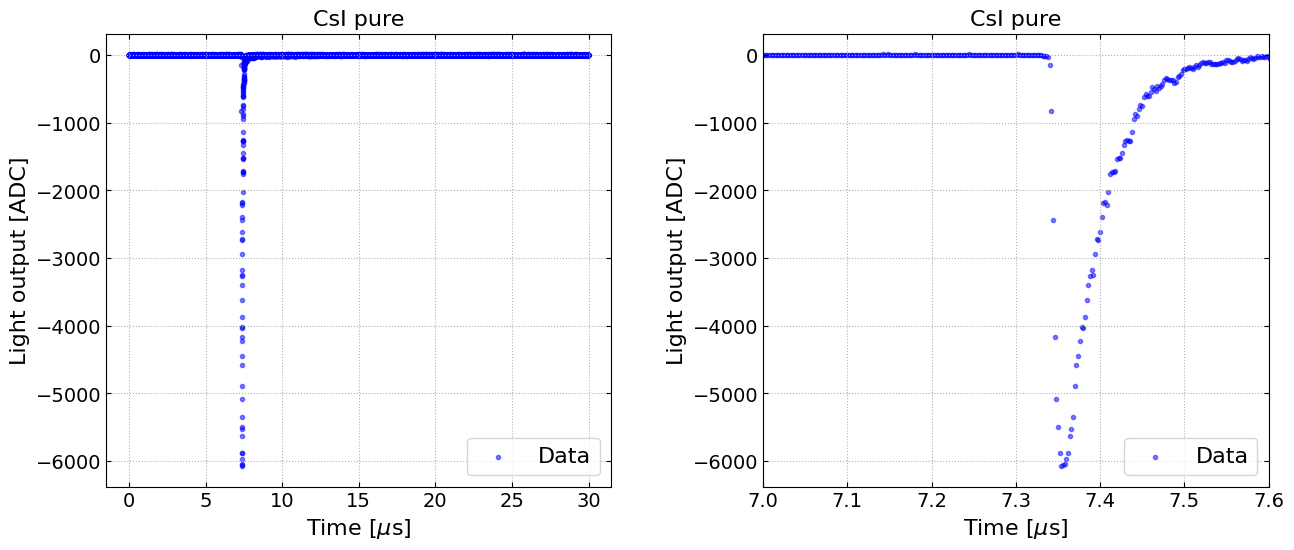

In [12]:
                                                                    

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 6), gridspec_kw={'wspace': 0.3})
ax1.scatter(np.arange(15000)*2e-3, np.load('trace13.npy'), label='Data', color='blue', marker = '.' , alpha=0.5)
# ax1.plot(np.arange(15000)*2e-3, amp_EM*np.roll(TemplateEM_p, round(t0_EM*1/2e-9)), 
#         label='OF fit EM', color='green',linewidth ='1.5')#, linestyle='dotted')
# ax1.plot(np.arange(15000)*2e-3, amp_Had*np.roll(TemplateHAD_p, round(t0_Had*1/2e-9)), 
#         label='OF fit Had', color='red',linewidth ='1.5')#, linestyle='dotted')
ax1.set_ylabel(r'Light output [ADC]',fontsize = 16)
ax1.set_xlabel(r'Time [$\mu$s]',fontsize = 16)
ax1.set_title('CsI pure',fontsize = 16)
lgd = ax1.legend(loc='lower right',fontsize = 16)
ax1.tick_params(which='both', direction='in', right=True, top=True)
ax1.grid(linestyle='dotted')


ax2.scatter(np.arange(15000)*2e-3, np.load('trace13.npy'), label='Data', color='blue', marker = '.' , alpha=0.5)
# ax2.plot(np.arange(15000)*2e-3, amp_EM*np.roll(TemplateEM_p, round(t0_EM*1/2e-9)+0), 
#         label='OF fit EM', color='green',linewidth ='1.5')#, linestyle='dotted')
# ax2.plot(np.arange(15000)*2e-3, amp_Had*np.roll(TemplateHAD_p, round(t0_Had*1/2e-9)+0), 
#         label='OF fit Had', color='red',linewidth ='1.5')#, linestyle='dotted')
ax1.set_ylabel(r'Light output [ADC]',fontsize = 16)
ax2.set_xlim(7,7.6)
ax2.set_ylabel(r'Light output [ADC]',fontsize = 16)
ax2.set_xlabel(r'Time [$\mu$s]',fontsize = 16)
ax2.set_title('CsI pure',fontsize = 16)
lgd = ax2.legend(loc='lower right',fontsize = 16)
ax2.tick_params(which='both', direction='in', right=True, top=True)
ax2.grid(linestyle='dotted')



In [33]:
np.savetxt('trace4.txt', np.load('trace4.npy'))


/home/s/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
